In [11]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sampling.sampler import Sampler
from benchmarks import german_credit
from benchmarks.benchmarks_mchmc import *

2023-07-05 10:09:11.519454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-05 10:09:12.856224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-05 10:09:12.856331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-05 10:09:12.856341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [12]:
names = ['Ill-Conditioned', 'Bi-Modal', 'Rosenbrock', "Neal's Funnel", 'German Credit', 'Stochastic Volatility']
targets = [IllConditionedGaussian(100, 100.0), BiModal(), Rosenbrock(), Funnel(), german_credit.Target(), StochasticVolatility()]


mchmc = pd.read_csv('submission/MCHMC/Table generalized_MN_q=0.csv')#, sep = '\t')
print(mchmc)
d = np.array([100, 50, 36, 20, 51, 2400])

L = np.array(mchmc['alpha'])*np.sqrt(d)
eps = np.array(mchmc['eps'])
grads = 1./np.array(mchmc['ESS'])

                 Target        ESS      alpha       eps
0        Ill-Conditioned  0.107438   1.309547  6.076026
1               Bi-Modal  0.063910   1.309547  8.836088
2             Rosenbrock  0.003275  15.583292  0.573738
3          Neal's Funnel  0.020841   1.219755  4.952272
4          German Credit  0.009931   1.435890  0.573738
5  Stochastic Volatility  0.012250   1.194322  1.198708


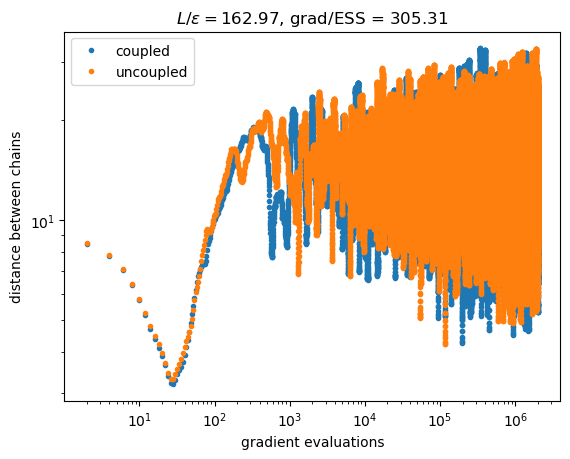

In [24]:
num = 2
steps = 1000000
target = targets[num]
sampler = Sampler(target, L[num], eps[num], diagonal_preconditioning= False, frac_tune1= 0, frac_tune2= 0, frac_tune3= 0)
key = jax.random.PRNGKey(42)
key, key1, key2, key3, key4 = jax.random.split(key, 5)
init1 = target.prior_draw(key1)
init2 = target.prior_draw(key2)
x1 = sampler.sample(steps, x_initial = init1, random_key = key)
x2 = sampler.sample(steps, x_initial = init2, random_key = key)
x3 = sampler.sample(steps, x_initial = init1, random_key = key3)
x4 = sampler.sample(steps, x_initial = init2, random_key = key4)

r = jnp.sqrt(jnp.sum(jnp.square(x1-x2), axis = -1))
plt.plot(jnp.arange(1, len(r)+1) * 2, r, '.', label = 'coupled')

r = jnp.sqrt(jnp.sum(jnp.square(x3-x4), axis = -1))
plt.plot(jnp.arange(1, len(r)+1) * 2, r, '.', label = 'uncoupled')

plt.ylabel('distance between chains')
plt.xlabel('gradient evaluations')
plt.title(r"$L / \epsilon = $" + str(np.round(L[num]/eps[num], 2)) + ', grad/ESS = ' + str(np.round(grads[num], 2)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('plots/coupling/'+names[num]+'.png')
plt.show()